In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os
import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import dateutil
import seaborn as sns

#set pwd
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

current directory is : C:\Users\D4rkmatter\Documents\GitHub\insurance-claim-forecast
Directory name is : insurance-claim-forecast


<h1>Claim Data</h1>

In [425]:
claimdata=pd.read_csv('claimdata.csv')
#Clean Data to months
claimdata['ClaimDate'] =  pd.to_datetime(claimdata['ClaimDate'])
claimdata['ClaimDate'] = claimdata['ClaimDate'].dt.strftime('%b %Y') #Consider dropping year for training (year may not be important) --> false
claimdata.shape

(37049, 4)

<h2>Consolidate Claims into same month</h2>

In [430]:
group = claimdata.groupby(['PetId','ClaimDate'])
claimdata = group.aggregate(np.sum)
claimdata = claimdata.reset_index()

,PetId,ClaimDate,ClaimId,ClaimAmount
0,2,Apr 2018,24729,346.61
1,2,Aug 2018,13987,190.69
2,2,Dec 2015,35612,75.32
3,2,Dec 2017,35613,567.32
4,2,Feb 2018,7633,82.80
...,...,...,...,...
22695,9998,Dec 2016,35689,5939.08
22696,9998,Jul 2016,6869,299.62
22697,9998,Mar 2016,3260,587.73
22698,9998,May 2016,35401,123.75


In [434]:
claimdata.shape

(22700, 4)

<h2>Claimdata Simple Exploration</h2>

In [435]:
claimdata.ClaimAmount.describe()
#claimdata.ClaimAmount.median()

count    22700.000000
mean       664.278259
std       1522.820667
min          1.400000
25%         90.317500
50%        217.945000
75%        559.372500
max      48691.460000
Name: ClaimAmount, dtype: float64

In [436]:
claimdata

,PetId,ClaimDate,ClaimId,ClaimAmount
0,2,Apr 2018,24729,346.61
1,2,Aug 2018,13987,190.69
2,2,Dec 2015,35612,75.32
3,2,Dec 2017,35613,567.32
4,2,Feb 2018,7633,82.80
...,...,...,...,...
22695,9998,Dec 2016,35689,5939.08
22696,9998,Jul 2016,6869,299.62
22697,9998,Mar 2016,3260,587.73
22698,9998,May 2016,35401,123.75


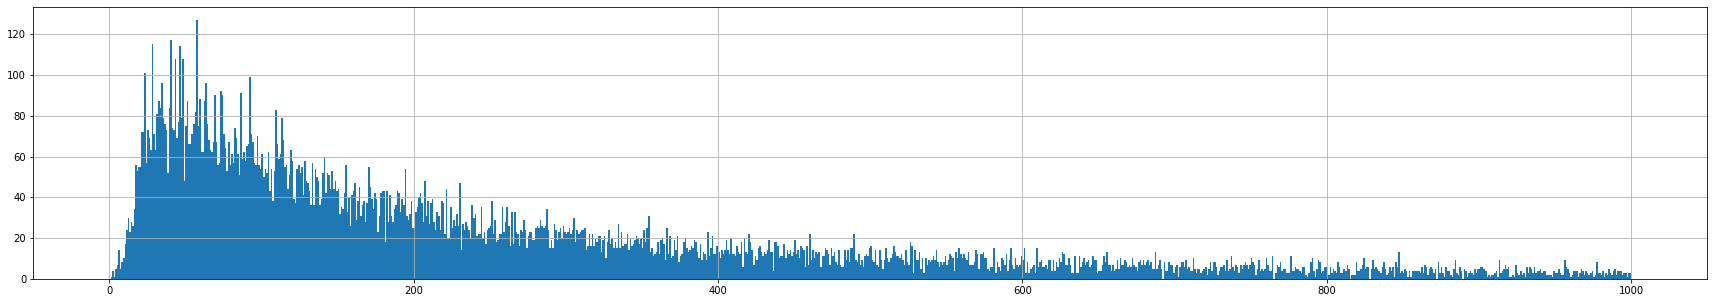

In [437]:
claimdata.ClaimAmount.hist(bins=1000,figsize=(30,5),range=(0,1000)) #3 std ~= 3500


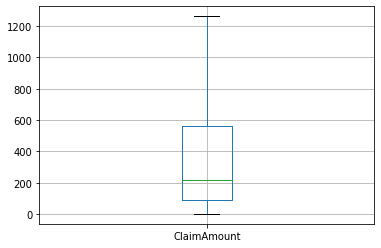

In [438]:
claimdata.boxplot(column='ClaimAmount',showfliers=False)

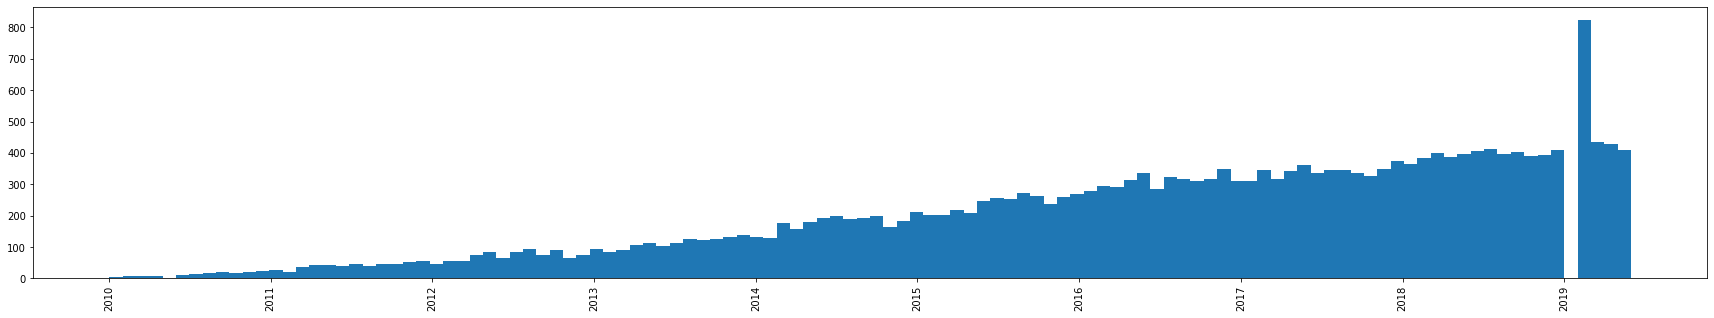

In [439]:
temp = claimdata
#reset dates for sorting
temp.ClaimDate = pd.to_datetime(temp.ClaimDate)
temp.sort_index(inplace=True)
temp.ClaimDate.hist(figsize=(30,5),grid=False, bins=len(temp.ClaimDate.unique()))
plt.xticks(rotation='vertical')
plt.show()

#NOTE, Year must stay
#NOTE, must reset strftime dates?

In [ ]:
claimdata['ClaimDate'].isnull().values.any()

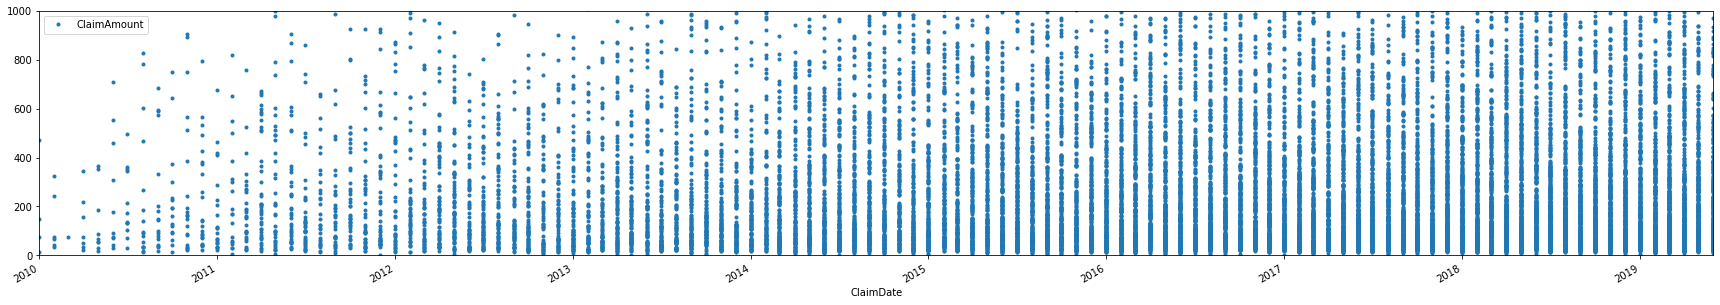

In [440]:
temp.plot(x='ClaimDate',y='ClaimAmount',style='.',figsize=(30,5),ylim=(0,1000))
#NOTE, must reset strftime dates?

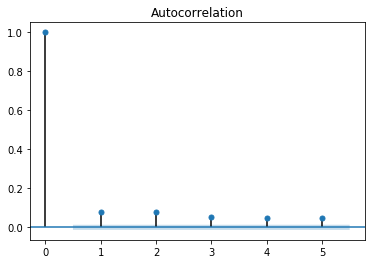

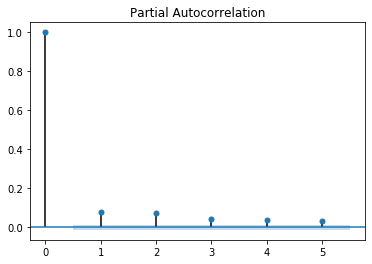

In [443]:
#set date as index
temp.set_index('ClaimDate')
temp = temp['ClaimAmount']
plot_acf(temp,lags=5)
plot_pacf(temp,lags=5)
plt.show()

In [442]:
claimdata['ClaimDate'] = claimdata['ClaimDate'].dt.strftime('%b %Y')

,PetId,ClaimDate,ClaimId,ClaimAmount
0,2,2018-04-01,24729,346.61
1,2,2018-08-01,13987,190.69
2,2,2015-12-01,35612,75.32
3,2,2017-12-01,35613,567.32
4,2,2018-02-01,7633,82.80
...,...,...,...,...
22695,9998,2016-12-01,35689,5939.08
22696,9998,2016-07-01,6869,299.62
22697,9998,2016-03-01,3260,587.73
22698,9998,2016-05-01,35401,123.75


<h1>Pet Data</h1>

In [444]:
petdata=pd.read_csv('petdata.csv')

In [465]:
petdata['EnrollDate'] =  pd.to_datetime(petdata['EnrollDate'])
petdata['CancelDate'] =  pd.to_datetime(petdata['CancelDate'])
petdata['EnrollDate'] = petdata['EnrollDate'].dt.strftime('%b %Y')
petdata['CancelDate'] = petdata['CancelDate'].dt.strftime('%b %Y')

#NOTE, if CancelDate != NaT ==> prediction == 0
#Note, ~= 50% are closed accounts

#petdata.query('CancelDate == "NaT"')

#Data to Categorical
petdata['Species'] = petdata['Species'].astype('category')
petdata['AgeAtEnroll'] = petdata['AgeAtEnroll'].astype('category')
petdata['Breed'] = petdata['Breed'].astype('category')
petdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
PetId          10000 non-null int64
EnrollDate     10000 non-null object
CancelDate     10000 non-null object
Species        10000 non-null category
Breed          10000 non-null category
AgeAtEnroll    10000 non-null category
dtypes: category(3), int64(1), object(2)
memory usage: 264.8+ KB


https://keras-pandas.readthedocs.io/en/latest/autosummary/data_types.Categorical.Categorical.html
    https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

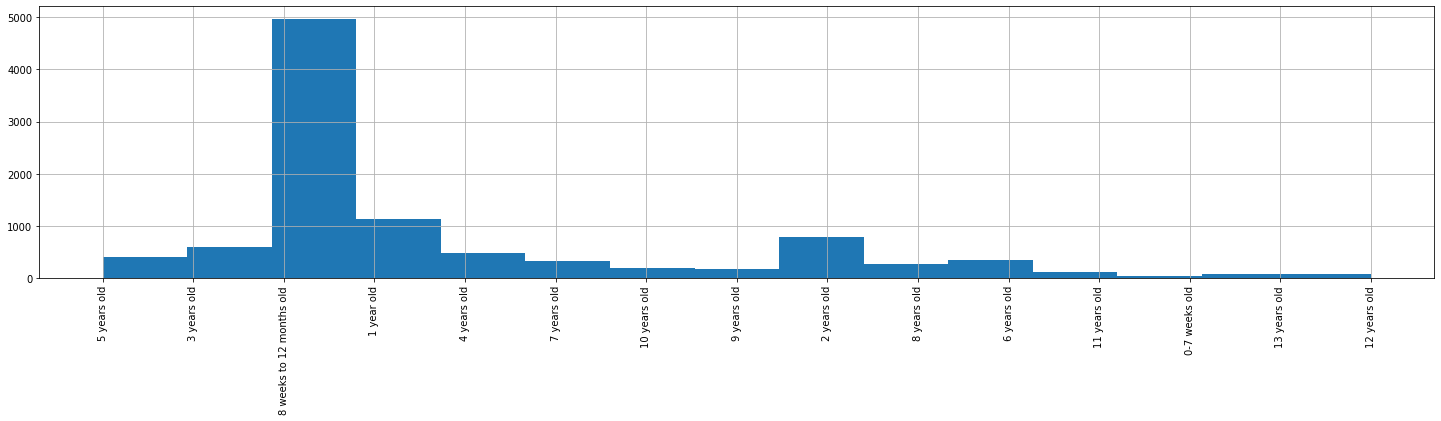

In [482]:

plt.xticks(rotation='vertical')
petdata['AgeAtEnroll'].hist(figsize=(25,5),bins=(len(petdata.AgeAtEnroll.unique())))


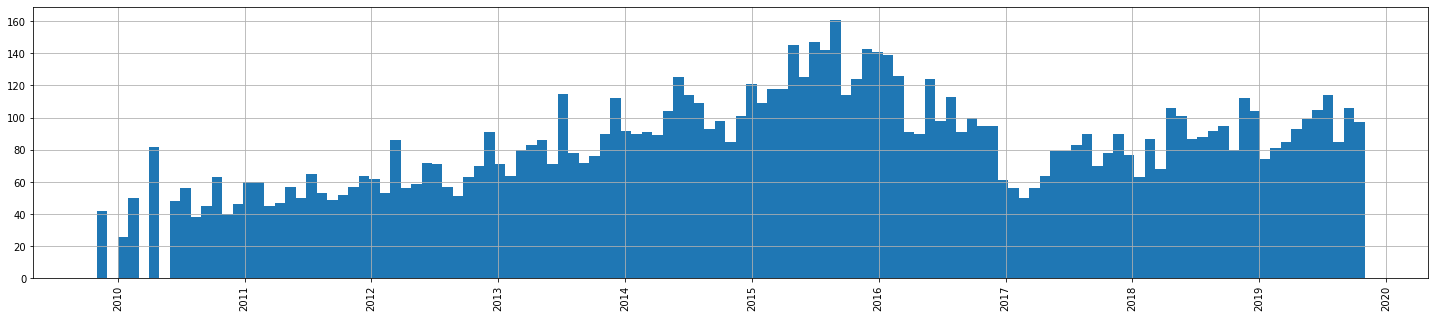

In [491]:
enroll_temp = petdata
#reset dates for sorting
enroll_temp.EnrollDate = pd.to_datetime(enroll_temp.EnrollDate)
enroll_temp.sort_index(inplace=True)
plt.xticks(rotation='vertical')
petdata['EnrollDate'].hist(figsize=(25,5),bins=(len(enroll_temp.EnrollDate.unique())))


In [492]:
petdata['EnrollDate'] = petdata['EnrollDate'].dt.strftime('%b %Y')
petdata

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,Aug 2015,Jul 2018,Dog,Mixed Breed,5 years old
1,1,Feb 2014,Jan 2016,Cat,Mixed Breed,3 years old
2,2,Dec 2014,NaT,Dog,French Bulldog,8 weeks to 12 months old
3,3,Jan 2015,Jan 2015,Dog,Mixed Breed,1 year old
4,4,Jul 2014,NaT,Cat,Mixed Breed,8 weeks to 12 months old
...,...,...,...,...,...,...
9995,9995,Feb 2019,NaT,Cat,Mixed Breed,6 years old
9996,9996,Dec 2016,Dec 2018,Cat,Mixed Breed,8 weeks to 12 months old
9997,9997,Jan 2015,Mar 2015,Dog,Mixed Breed,8 weeks to 12 months old
9998,9998,Nov 2015,NaT,Cat,Mixed Breed,8 weeks to 12 months old


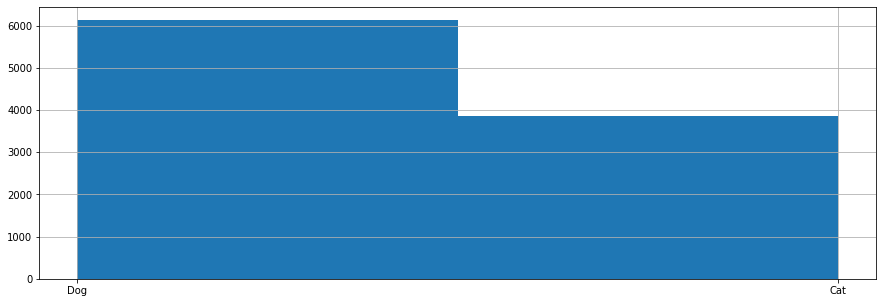

In [496]:
petdata['Species'].hist(figsize=(15,5),bins=(len(petdata.Species.unique())))

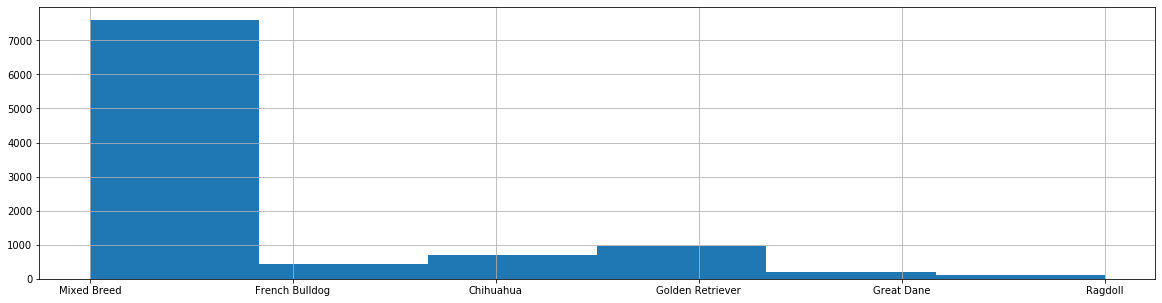

In [493]:
petdata['Breed'].hist(figsize=(20,5),bins=(len(petdata.Breed.unique())))

<h2>Balancing classes</h2>
<p>Breed and AgeAtEnroll are imbalanced</p>
<p>Options: <br>
Downsample (Concern for amount of data) <br>
Up sample (overfitting) <br>
Stick with random forests... (may not be accurate) <br>
PCA/Clustering to remove??</p>

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
